In [19]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import os
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import parameter_optimization as po
import pickle

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1k/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

# pull in flags_df and limit to iMs listed
flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)
flags_df = flags_df[flags_df['include'] == True]

In [20]:
# settings loading data
# settings
case = 'Arginine'
metabolites = ['Arginine']#['Guanine', 'Hypoxanthine']
act_iM = None
inh_iM = 'Arginine'
plot_gene = 'argA'
plot_regulator = 'argR'

if True:
    true_false = []
    for act, inh in zip(flags_df['act_iM'], flags_df['inh_iM']):
        if act in [case] or inh in [case]:
            true_false.append(True)
        else:
            true_false.append(False)
    bby_flags_df = flags_df.loc[true_false]

    # load in relevant data
    starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
    # above is in (µM) , convert to M
    starve_metabs[starve_metabs.columns[1:]] *= 1e-6
    starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
    #starve_cols = list(set(starve_log_tpm.columns).intersection(actual_df.columns))

    iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
    run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
    GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
    GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    metab_df = inh_metab_df[inh_metab_df['iM'] == case]
    cAct_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cAct_mapping.csv', index_col = 0)
    cInh_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cInh_mapping.csv', index_col = 0)



    # grab genes
    genes = cInh_mapping[cInh_mapping[inh_iM] != 0].index.to_list()

    # load in for loop
    calc_cInh = GAMS_calc_cInh[genes]
    calc_cAct = GAMS_calc_cAct[genes]
    mRNA_ratio_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0).loc[calc_cInh.index]


    # creating actual and reconstructed mRNA values
    all_shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    recons_mRNAs = []
    actual_mRNAs = []
    indices_for_recons = []
    grid = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0)
    ratios_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0)
    for gene in calc_cAct.columns:
        shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)).intersection(ratios_df.index[ratios_df[gene].notnull()]))

        actual_mRNAs.append(ratios_df.loc[shared][gene])
        # setup
        #po.create_shared_lambda_df(stable_flags['eq_str'], dict(grid[gene]))
        pickle_in = open('../data/lambda_dfs/'+gene+'.pkl', 'rb')
        lambda_df = pickle.load(pickle_in)
        pickle_in.close()

        recon_mRNA = []
        for sample in shared:
            cAct = calc_cAct[gene].loc[sample]
            cInh = calc_cInh[gene].loc[sample]
            lambda_df1 = lambda_df[gene].loc[sample]
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid[gene].loc['KdRNAPCrp'], lambda_df_input = lambda_df1))
        recons_mRNAs.append(recon_mRNA)
        indices_for_recons.append(gene)

    # save recon
    recon_df = pd.DataFrame(recons_mRNAs, index = indices_for_recons, columns = all_shared)
    actual_df = pd.DataFrame(actual_mRNAs, index = indices_for_recons, columns = all_shared)

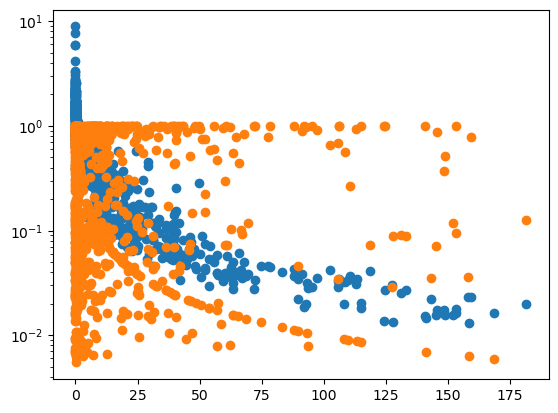

In [26]:
# plotting

plt.scatter(calc_cInh[gene_to_b[plot_gene]], mRNA_ratio_df[gene_to_b[plot_gene]])
plt.scatter(calc_cInh[gene_to_b[plot_gene]], recon_df[mRNA_ratio_df.index].loc[gene_to_b[plot_gene]])
plt.yscale('log')
plt.show()

In [32]:
mRNA_ratio_df[[gene_to_b[plot_gene]]]

,b2818
p1k_00040,1.397902
p1k_01008,0.654503
p1k_00971,0.668994
p1k_00886,1.715660
p1k_00946,0.494703
...,...
p1k_00834,0.109106
p1k_00399,0.617072
starve_series__t16_starve,0.033827
p1k_00420,1.322775


In [37]:
recon_df[mRNA_ratio_df.index].loc[[gene_to_b[plot_gene]]].T

,b2818
p1k_00040,0.997717
p1k_01008,0.362230
p1k_00971,0.102839
p1k_00886,0.997717
p1k_00946,0.098540
...,...
p1k_00834,0.029779
p1k_00399,0.342017
starve_series__t16_starve,0.009043
p1k_00420,0.874524


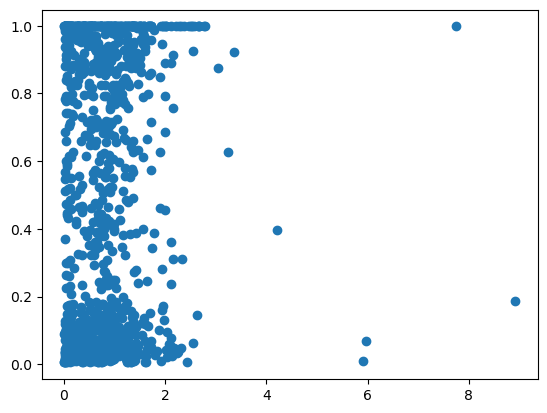

In [39]:
plt.scatter(mRNA_ratio_df[gene_to_b[plot_gene]], recon_df[mRNA_ratio_df.index].loc[[gene_to_b[plot_gene]]].T)
#plt.yscale('log')

In [24]:
recon_df[mRNA_ratio_df.index]

,p1k_00040,p1k_01008,p1k_00971,p1k_00886,p1k_00946,p1k_01052,p1k_00022,p1k_00067,p1k_00294,p1k_00213,...,p1k_00611,p1k_00765,p1k_00489,p1k_00877,p1k_00083,p1k_00834,p1k_00399,starve_series__t16_starve,p1k_00420,p1k_00630
b3957,0.999666,0.795686,0.440082,0.999666,0.428417,0.999666,0.172436,0.999666,0.928923,0.766113,...,0.641666,0.608232,0.131525,0.097623,0.877107,0.173867,0.780901,0.058885,0.979504,0.500577
b3958,0.996491,0.269537,0.069309,0.996491,0.066308,0.996491,0.019360,0.996491,0.553232,0.236850,...,0.145056,0.128238,0.014146,0.010146,0.403428,0.019551,0.252449,0.005894,0.819104,0.086732
b3960,0.998566,0.475074,0.154445,0.998566,0.148345,0.998566,0.046186,0.998566,0.752302,0.432210,...,0.293856,0.265136,0.033998,0.024524,0.623865,0.046628,0.453037,0.014332,0.917396,0.188923
b3959,0.998002,0.393521,0.115791,0.998002,0.111017,0.998002,0.033552,0.998002,0.685287,0.353066,...,0.229793,0.205512,0.024612,0.017706,0.543201,0.033877,0.372582,0.010317,0.888422,0.143100
b3359,0.999247,0.632855,0.258096,0.999247,0.249109,0.999247,0.084438,0.999247,0.852607,0.591805,...,0.442146,0.407292,0.062820,0.045696,0.759558,0.085214,0.612033,0.026948,0.954858,0.307304
b0273,0.994853,0.200721,0.048238,0.994853,0.046104,0.994853,0.013258,0.994853,0.457332,0.174387,...,0.103517,0.091002,0.009671,0.006928,0.315177,0.013389,0.186879,0.004019,0.755001,0.060709
b4254,0.991990,0.138604,0.031453,0.991990,0.030038,0.991990,0.008536,0.991990,0.350642,0.119205,...,0.068890,0.060280,0.006218,0.004450,0.227732,0.008621,0.128358,0.002579,0.663812,0.039766
b3172,0.998840,0.528056,0.184217,0.998840,0.177188,0.998840,0.056484,0.998840,0.789689,0.484827,...,0.339707,0.308462,0.041697,0.030145,0.672191,0.057019,0.505930,0.017659,0.932113,0.223585
b2818,0.997717,0.362230,0.102839,0.997717,0.098540,0.997717,0.029492,0.997717,0.655885,0.323277,...,0.207076,0.184619,0.021609,0.015532,0.510017,0.029779,0.342017,0.009043,0.874524,0.127534


In [15]:
calc_cInh[gene_to_b[gene]]

KeyError: 'b2818'